In [1]:
"""
NH₃ QML Results Reader
======================

Read and visualize results from NH₃ QML comparison experiments.

Usage (command line):
    python read_results_nh3.py results_dir --plot all --save_dir figures

Usage (Jupyter):
    from read_results_nh3 import main, ResultsReader
    reader = main('results_dir', plot='all', save_dir='figures')
    # or
    reader = ResultsReader('results_dir')
    reader.print_summary()
    reader.plot_comparison_bars()
"""

import numpy as np
import json
import os
import argparse
import matplotlib.pyplot as plt


class ResultsReader:
    """Read and analyze NH₃ QML comparison results."""
    
    def __init__(self, results_dir):
        """
        Initialize reader.
        
        Args:
            results_dir: Directory containing results.json and metrics.npz
        """
        self.results_dir = results_dir
        self.results = None
        self.metrics = None
        
        self._load_results()
    
    def _load_results(self):
        """Load results from JSON and NPZ files."""
        json_path = os.path.join(self.results_dir, "results.json")
        npz_path = os.path.join(self.results_dir, "metrics.npz")
        
        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                self.results = json.load(f)
            print(f"Loaded results from {json_path}")
        else:
            print(f"Warning: {json_path} not found")
        
        if os.path.exists(npz_path):
            self.metrics = dict(np.load(npz_path))
            print(f"Loaded metrics from {npz_path}")
        else:
            print(f"Warning: {npz_path} not found")
    
    def print_summary(self):
        """Print summary statistics."""
        if self.results is None:
            print("No results loaded")
            return
        
        print(f"\n{'='*70}")
        print("NH₃ QML COMPARISON SUMMARY")
        print(f"{'='*70}")
        
        meta = self.results.get("metadata", {})
        print(f"\nExperiment Details:")
        print(f"  Runs: {meta.get('n_runs', 'N/A')}")
        print(f"  Epochs: {meta.get('n_epochs', 'N/A')}")
        print(f"  Samples: {meta.get('n_samples', 'N/A')}")
        print(f"  Timestamp: {meta.get('timestamp', 'N/A')}")
        
        for model_name, display_name in [("equivariant", "Equivariant (EQNN-style)"), 
                                          ("graph_qml", "Graph QML (Non-Equivariant)")]:
            if model_name not in self.results:
                continue
            
            summary = self.results[model_name].get("summary", {})
            print(f"\n{display_name}:")
            
            if "energy_r2" in summary:
                er2 = summary["energy_r2"]
                print(f"  Energy R²:  {er2['mean']:.4f} ± {er2['std']:.4f}")
            
            if "energy_mae_ha" in summary:
                emae = summary["energy_mae_ha"]
                print(f"  Energy MAE: {emae['mean']:.6f} ± {emae['std']:.6f} Ha")
                print(f"              {emae['mean']*27.2114:.4f} ± {emae['std']*27.2114:.4f} eV")
            
            if "force_r2" in summary:
                fr2 = summary["force_r2"]
                print(f"  Force R²:   {fr2['mean']:.4f} ± {fr2['std']:.4f}")
            
            if "force_mae" in summary:
                fmae = summary["force_mae"]
                print(f"  Force MAE:  {fmae['mean']:.4f} ± {fmae['std']:.4f} eV/Å")
        
        print(f"\n{'='*70}\n")
    
    def plot_comparison_bars(self, save_path=None, show=True):
        """Plot R² comparison bar chart."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        models = ["Equivariant", "Graph QML"]
        colors = ["#2ecc71", "#3498db"]
        
        # Energy R²
        eq_e = self.results["equivariant"]["summary"]["energy_r2"]
        gr_e = self.results["graph_qml"]["summary"]["energy_r2"]
        
        means = [eq_e["mean"], gr_e["mean"]]
        stds = [eq_e["std"], gr_e["std"]]
        
        x = np.arange(len(models))
        bars = axes[0].bar(x, means, yerr=stds, capsize=5, color=colors, 
                          edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel("R²", fontsize=12)
        axes[0].set_title("Energy Prediction R²", fontsize=14, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(models, fontsize=11)
        axes[0].set_ylim([0, 1.1])
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, m, s in zip(bars, means, stds):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + s + 0.03,
                        f'{m:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Force R²
        eq_f = self.results["equivariant"]["summary"]["force_r2"]
        gr_f = self.results["graph_qml"]["summary"]["force_r2"]
        
        means = [eq_f["mean"], gr_f["mean"]]
        stds = [eq_f["std"], gr_f["std"]]
        
        bars = axes[1].bar(x, means, yerr=stds, capsize=5, color=colors,
                          edgecolor='black', linewidth=1.5)
        axes[1].set_ylabel("R²", fontsize=12)
        axes[1].set_title("Force Prediction R²", fontsize=14, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(models, fontsize=11)
        axes[1].set_ylim([0, 1.1])
        axes[1].grid(True, alpha=0.3, axis='y')
        
        for bar, m, s in zip(bars, means, stds):
            height = max(0, bar.get_height())
            axes[1].text(bar.get_x() + bar.get_width()/2, height + s + 0.03,
                        f'{m:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.suptitle("NH₃: Equivariant vs Graph QML Comparison", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_mae_comparison(self, save_path=None, show=True):
        """Plot MAE comparison bar chart."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        models = ["Equivariant", "Graph QML"]
        colors = ["#2ecc71", "#3498db"]
        x = np.arange(len(models))
        
        # Energy MAE (in meV)
        eq_e = self.results["equivariant"]["summary"]["energy_mae_ha"]
        gr_e = self.results["graph_qml"]["summary"]["energy_mae_ha"]
        
        # Convert to meV (1 Ha = 27211.4 meV)
        means = [eq_e["mean"] * 27211.4, gr_e["mean"] * 27211.4]
        stds = [eq_e["std"] * 27211.4, gr_e["std"] * 27211.4]
        
        bars = axes[0].bar(x, means, yerr=stds, capsize=5, color=colors,
                          edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel("MAE (meV)", fontsize=12)
        axes[0].set_title("Energy MAE", fontsize=14, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(models, fontsize=11)
        axes[0].grid(True, alpha=0.3, axis='y')
        
        for bar, m, s in zip(bars, means, stds):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + s + 0.5,
                        f'{m:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Force MAE
        eq_f = self.results["equivariant"]["summary"]["force_mae"]
        gr_f = self.results["graph_qml"]["summary"]["force_mae"]
        
        means = [eq_f["mean"], gr_f["mean"]]
        stds = [eq_f["std"], gr_f["std"]]
        
        bars = axes[1].bar(x, means, yerr=stds, capsize=5, color=colors,
                          edgecolor='black', linewidth=1.5)
        axes[1].set_ylabel("MAE (eV/Å)", fontsize=12)
        axes[1].set_title("Force MAE", fontsize=14, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(models, fontsize=11)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        for bar, m, s in zip(bars, means, stds):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + s + 0.02,
                        f'{m:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.suptitle("NH₃: Model MAE Comparison", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_training_curves(self, save_path=None, show=True):
        """Plot training loss curves."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Equivariant training curves
        eq_runs = self.results["equivariant"]["runs"]
        
        # Collect all histories
        eq_total = []
        eq_energy = []
        eq_force = []
        
        for run in eq_runs:
            history = run.get("history", {})
            if "total" in history:
                eq_total.append(history["total"])
            if "energy" in history:
                eq_energy.append(history["energy"])
            if "force" in history:
                eq_force.append(history["force"])
        
        if eq_total:
            eq_total = np.array(eq_total)
            mean = np.mean(eq_total, axis=0)
            std = np.std(eq_total, axis=0)
            steps = np.arange(len(mean))
            
            axes[0, 0].plot(steps, mean, 'k-', lw=2, label='Total')
            axes[0, 0].fill_between(steps, mean - std, mean + std, alpha=0.3, color='gray')
            
            if eq_energy:
                eq_energy = np.array(eq_energy)
                mean_e = np.mean(eq_energy, axis=0)
                axes[0, 0].plot(steps, mean_e, 'r--', lw=1.5, label='Energy')
            
            if eq_force:
                eq_force = np.array(eq_force)
                mean_f = np.mean(eq_force, axis=0)
                axes[0, 0].plot(steps, mean_f, 'b--', lw=1.5, label='Force')
        
        axes[0, 0].set_yscale('log')
        axes[0, 0].set_xlabel('Epoch', fontsize=12)
        axes[0, 0].set_ylabel('Loss', fontsize=12)
        axes[0, 0].set_title('Equivariant Training', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Graph QML training curves - Phase 1 (Energy)
        graph_runs = self.results["graph_qml"]["runs"]
        
        graph_energy_phase = []
        for run in graph_runs:
            history = run.get("history", {})
            if "energy_phase" in history:
                graph_energy_phase.append(history["energy_phase"])
        
        if graph_energy_phase:
            # Pad to same length
            max_len = max(len(h) for h in graph_energy_phase)
            padded = []
            for h in graph_energy_phase:
                if len(h) < max_len:
                    h = h + [h[-1]] * (max_len - len(h))
                padded.append(h)
            
            graph_energy_phase = np.array(padded)
            mean = np.mean(graph_energy_phase, axis=0)
            std = np.std(graph_energy_phase, axis=0)
            steps = np.arange(len(mean))
            
            axes[0, 1].plot(steps, mean, 'r-', lw=2, label='Energy Loss')
            axes[0, 1].fill_between(steps, mean - std, mean + std, alpha=0.3, color='red')
        
        axes[0, 1].set_yscale('log')
        axes[0, 1].set_xlabel('Epoch', fontsize=12)
        axes[0, 1].set_ylabel('Loss', fontsize=12)
        axes[0, 1].set_title('Graph QML Phase 1: Energy Only', fontsize=14, fontweight='bold')
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Graph QML training curves - Phase 2 (Combined)
        graph_combined_E = []
        graph_combined_F = []
        
        for run in graph_runs:
            history = run.get("history", {})
            if "combined_E" in history:
                graph_combined_E.append(history["combined_E"])
            if "combined_F" in history:
                graph_combined_F.append(history["combined_F"])
        
        if graph_combined_E:
            max_len = max(len(h) for h in graph_combined_E)
            padded_E = []
            padded_F = []
            for e, f in zip(graph_combined_E, graph_combined_F):
                if len(e) < max_len:
                    e = e + [e[-1]] * (max_len - len(e))
                    f = f + [f[-1]] * (max_len - len(f))
                padded_E.append(e)
                padded_F.append(f)
            
            graph_combined_E = np.array(padded_E)
            graph_combined_F = np.array(padded_F)
            
            steps = np.arange(graph_combined_E.shape[1])
            
            mean_E = np.mean(graph_combined_E, axis=0)
            std_E = np.std(graph_combined_E, axis=0)
            axes[1, 0].plot(steps, mean_E, 'r-', lw=2, label='Energy')
            axes[1, 0].fill_between(steps, mean_E - std_E, mean_E + std_E, alpha=0.3, color='red')
            
            mean_F = np.mean(graph_combined_F, axis=0)
            std_F = np.std(graph_combined_F, axis=0)
            axes[1, 0].plot(steps, mean_F, 'b-', lw=2, label='Force')
            axes[1, 0].fill_between(steps, mean_F - std_F, mean_F + std_F, alpha=0.3, color='blue')
        
        axes[1, 0].set_yscale('log')
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('Loss', fontsize=12)
        axes[1, 0].set_title('Graph QML Phase 2: Energy + Forces', fontsize=14, fontweight='bold')
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Summary comparison
        summary_data = {
            'Equivariant': {
                'E_R²': self.results["equivariant"]["summary"]["energy_r2"]["mean"],
                'F_R²': self.results["equivariant"]["summary"]["force_r2"]["mean"],
            },
            'Graph QML': {
                'E_R²': self.results["graph_qml"]["summary"]["energy_r2"]["mean"],
                'F_R²': self.results["graph_qml"]["summary"]["force_r2"]["mean"],
            }
        }
        
        models = list(summary_data.keys())
        x = np.arange(len(models))
        width = 0.35
        
        e_r2 = [summary_data[m]['E_R²'] for m in models]
        f_r2 = [summary_data[m]['F_R²'] for m in models]
        
        axes[1, 1].bar(x - width/2, e_r2, width, label='Energy R²', color='#e74c3c', edgecolor='black')
        axes[1, 1].bar(x + width/2, f_r2, width, label='Force R²', color='#3498db', edgecolor='black')
        
        axes[1, 1].set_ylabel('R²', fontsize=12)
        axes[1, 1].set_title('Final Performance Summary', fontsize=14, fontweight='bold')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(models, fontsize=11)
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].set_ylim([0, 1.1])
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (e, f) in enumerate(zip(e_r2, f_r2)):
            axes[1, 1].text(i - width/2, e + 0.03, f'{e:.3f}', ha='center', fontsize=9, fontweight='bold')
            axes[1, 1].text(i + width/2, max(0, f) + 0.03, f'{f:.3f}', ha='center', fontsize=9, fontweight='bold')
        
        plt.suptitle("NH₃ QML Training Analysis", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_predictions(self, run_idx=0, save_path=None, show=True):
        """Plot prediction scatter plots for a specific run."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Get predictions from specified run
        eq_run = self.results["equivariant"]["runs"][run_idx]
        graph_run = self.results["graph_qml"]["runs"][run_idx]
        
        eq_preds = eq_run["metrics"]["predictions"]
        graph_preds = graph_run["metrics"]["predictions"]
        
        # Equivariant Energy
        E_true = np.array(eq_preds["E_true"])
        E_pred = np.array(eq_preds["E_pred"])
        
        axes[0, 0].scatter(E_true, E_pred, alpha=0.6, s=30, c='#2ecc71', edgecolors='black', linewidth=0.5)
        lims = [min(E_true.min(), E_pred.min()), max(E_true.max(), E_pred.max())]
        axes[0, 0].plot(lims, lims, 'k--', lw=2)
        axes[0, 0].set_xlabel('True Energy (Ha)', fontsize=11)
        axes[0, 0].set_ylabel('Predicted Energy (Ha)', fontsize=11)
        r2 = eq_run["metrics"]["energy"]["r2"]
        axes[0, 0].set_title(f'Equivariant Energy (R²={r2:.3f})', fontsize=13, fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Equivariant Force
        F_true = np.array(eq_preds["F_true"]).flatten()
        F_pred = np.array(eq_preds["F_pred"]).flatten()
        
        axes[0, 1].scatter(F_true, F_pred, alpha=0.4, s=15, c='#2ecc71', edgecolors='black', linewidth=0.3)
        lims = [min(F_true.min(), F_pred.min()), max(F_true.max(), F_pred.max())]
        axes[0, 1].plot(lims, lims, 'k--', lw=2)
        axes[0, 1].set_xlabel('True Force (eV/Å)', fontsize=11)
        axes[0, 1].set_ylabel('Predicted Force (eV/Å)', fontsize=11)
        r2 = eq_run["metrics"]["force"]["r2"]
        axes[0, 1].set_title(f'Equivariant Force (R²={r2:.3f})', fontsize=13, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Graph QML Energy
        E_true = np.array(graph_preds["E_true"])
        E_pred = np.array(graph_preds["E_pred"])
        
        axes[1, 0].scatter(E_true, E_pred, alpha=0.6, s=30, c='#3498db', edgecolors='black', linewidth=0.5)
        lims = [min(E_true.min(), E_pred.min()), max(E_true.max(), E_pred.max())]
        axes[1, 0].plot(lims, lims, 'k--', lw=2)
        axes[1, 0].set_xlabel('True Energy (Ha)', fontsize=11)
        axes[1, 0].set_ylabel('Predicted Energy (Ha)', fontsize=11)
        r2 = graph_run["metrics"]["energy"]["r2"]
        axes[1, 0].set_title(f'Graph QML Energy (R²={r2:.3f})', fontsize=13, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Graph QML Force
        F_true = np.array(graph_preds["F_true"]).flatten()
        F_pred = np.array(graph_preds["F_pred"]).flatten()
        
        axes[1, 1].scatter(F_true, F_pred, alpha=0.4, s=15, c='#3498db', edgecolors='black', linewidth=0.3)
        lims = [min(F_true.min(), F_pred.min()), max(F_true.max(), F_pred.max())]
        axes[1, 1].plot(lims, lims, 'k--', lw=2)
        axes[1, 1].set_xlabel('True Force (eV/Å)', fontsize=11)
        axes[1, 1].set_ylabel('Predicted Force (eV/Å)', fontsize=11)
        r2 = graph_run["metrics"]["force"]["r2"]
        axes[1, 1].set_title(f'Graph QML Force (R²={r2:.3f})', fontsize=13, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f"NH₃ Predictions (Run {run_idx + 1})", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_force_components(self, run_idx=0, save_path=None, show=True):
        """Plot force predictions by atom and component."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(3, 3, figsize=(14, 12))
        fig.suptitle(f'NH₃ Force Predictions by Atom and Component (Run {run_idx + 1})', 
                     fontsize=16, fontweight='bold')
        
        atom_names = ['H₁', 'H₂', 'H₃']
        component_names = ['Fₓ', 'Fᵧ', 'Fᵤ']
        
        # Use equivariant predictions (or could compare both)
        eq_run = self.results["equivariant"]["runs"][run_idx]
        preds = eq_run["metrics"]["predictions"]
        
        F_true = np.array(preds["F_true"])  # (N_test, 3, 3)
        F_pred = np.array(preds["F_pred"])  # (N_test, 3, 3)
        
        for atom_idx in range(3):
            for comp_idx in range(3):
                ax = axes[atom_idx, comp_idx]
                
                f_true = F_true[:, atom_idx, comp_idx]
                f_pred = F_pred[:, atom_idx, comp_idx]
                
                ax.scatter(f_true, f_pred, alpha=0.6, s=25, c=f'C{atom_idx}', 
                          edgecolors='black', linewidth=0.3)
                
                lims = [min(f_true.min(), f_pred.min()), max(f_true.max(), f_pred.max())]
                ax.plot(lims, lims, 'k--', lw=1.5)
                
                # Compute R² for this component
                ss_res = np.sum((f_pred - f_true)**2)
                ss_tot = np.sum((f_true - f_true.mean())**2)
                r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0
                
                ax.set_xlabel(f'True {component_names[comp_idx]} (eV/Å)', fontsize=10)
                ax.set_ylabel(f'Pred {component_names[comp_idx]} (eV/Å)', fontsize=10)
                ax.set_title(f'{atom_names[atom_idx]} - {component_names[comp_idx]} (R²={r2:.3f})', 
                            fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_all(self, output_dir=None, show=True):
        """Generate all plots."""
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
        
        self.plot_comparison_bars(
            save_path=os.path.join(output_dir, "comparison_r2.png") if output_dir else None,
            show=show
        )
        
        self.plot_mae_comparison(
            save_path=os.path.join(output_dir, "comparison_mae.png") if output_dir else None,
            show=show
        )
        
        self.plot_training_curves(
            save_path=os.path.join(output_dir, "training_curves.png") if output_dir else None,
            show=show
        )
        
        self.plot_predictions(
            save_path=os.path.join(output_dir, "predictions.png") if output_dir else None,
            show=show
        )
        
        self.plot_force_components(
            save_path=os.path.join(output_dir, "force_components.png") if output_dir else None,
            show=show
        )
        
        if output_dir:
            print(f"\nAll plots saved to {output_dir}")
    
    def export_csv(self, filepath):
        """Export summary to CSV."""
        if self.results is None:
            print("No results to export")
            return
        
        lines = ["Model,Metric,Mean,Std"]
        
        for model_name, display_name in [("equivariant", "Equivariant"), ("graph_qml", "Graph_QML")]:
            summary = self.results[model_name]["summary"]
            
            lines.append(f"{display_name},Energy_R2,{summary['energy_r2']['mean']:.6f},{summary['energy_r2']['std']:.6f}")
            lines.append(f"{display_name},Energy_MAE_Ha,{summary['energy_mae_ha']['mean']:.6f},{summary['energy_mae_ha']['std']:.6f}")
            lines.append(f"{display_name},Force_R2,{summary['force_r2']['mean']:.6f},{summary['force_r2']['std']:.6f}")
            lines.append(f"{display_name},Force_MAE,{summary['force_mae']['mean']:.6f},{summary['force_mae']['std']:.6f}")
        
        with open(filepath, "w") as f:
            f.write("\n".join(lines))
        
        print(f"Exported to {filepath}")


def main(results_dir, plot='all', save_dir=None, csv=None, show=True):
    """
    Main function - can be called directly from Jupyter or command line.
    
    Args:
        results_dir: Directory containing results
        plot: Type of plot ('comparison', 'mae', 'training', 'predictions', 'force_components', 'all')
        save_dir: Directory to save plots (optional)
        csv: Path to export CSV (optional)
        show: Whether to display plots
    
    Returns:
        ResultsReader object
    """
    reader = ResultsReader(results_dir)
    reader.print_summary()
    
    if csv:
        reader.export_csv(csv)
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    if plot == 'all':
        reader.plot_all(output_dir=save_dir, show=show)
    elif plot == 'comparison':
        path = os.path.join(save_dir, "comparison_r2.png") if save_dir else None
        reader.plot_comparison_bars(save_path=path, show=show)
    elif plot == 'mae':
        path = os.path.join(save_dir, "comparison_mae.png") if save_dir else None
        reader.plot_mae_comparison(save_path=path, show=show)
    elif plot == 'training':
        path = os.path.join(save_dir, "training_curves.png") if save_dir else None
        reader.plot_training_curves(save_path=path, show=show)
    elif plot == 'predictions':
        path = os.path.join(save_dir, "predictions.png") if save_dir else None
        reader.plot_predictions(save_path=path, show=show)
    elif plot == 'force_components':
        path = os.path.join(save_dir, "force_components.png") if save_dir else None
        reader.plot_force_components(save_path=path, show=show)
    
    return reader


if __name__ == "__main__":
    import sys
    
    # Check if running in Jupyter
    if 'ipykernel' in sys.modules:
        print("Running in Jupyter notebook. Call main() directly with parameters:")
        print("  reader = main('nh3_comparison_results', plot='all', save_dir='figures', show=True)")
        print("\nOr use the ResultsReader class directly:")
        print("  reader = ResultsReader('nh3_comparison_results')")
        print("  reader.print_summary()")
        print("  reader.plot_comparison_bars()")
    else:
        parser = argparse.ArgumentParser(description="Read and analyze NH₃ QML comparison results")
        parser.add_argument("results_dir", help="Directory containing results")
        parser.add_argument("--plot", choices=['comparison', 'mae', 'training', 'predictions', 'force_components', 'all'],
                           default='all', help="Type of plot")
        parser.add_argument("--save_dir", type=str, help="Directory to save plots")
        parser.add_argument("--csv", type=str, help="Export to CSV")
        parser.add_argument("--no-show", action="store_true", help="Don't display plots")
        
        args = parser.parse_args()
        
        main(
            results_dir=args.results_dir,
            plot=args.plot,
            save_dir=args.save_dir,
            csv=args.csv,
            show=not args.no_show
        )

Running in Jupyter notebook. Call main() directly with parameters:
  reader = main('nh3_comparison_results', plot='all', save_dir='figures', show=True)

Or use the ResultsReader class directly:
  reader = ResultsReader('nh3_comparison_results')
  reader.print_summary()
  reader.plot_comparison_bars()


Loaded results from results/results.json
Loaded metrics from results/metrics.npz

NH₃ QML COMPARISON SUMMARY

Experiment Details:
  Runs: 2
  Epochs: 100
  Samples: 2400
  Timestamp: 2025-11-24T06:12:40.288148

Equivariant (EQNN-style):
  Energy R²:  0.7055 ± 0.0041
  Energy MAE: 0.156619 ± 0.002098 Ha
              4.2618 ± 0.0571 eV
  Force R²:   0.4855 ± 0.0174
  Force MAE:  19.4356 ± 0.9758 eV/Å

Graph QML (Non-Equivariant):
  Energy R²:  0.8024 ± 0.0171
  Energy MAE: 0.131807 ± 0.002911 Ha
              3.5866 ± 0.0792 eV
  Force R²:   0.7734 ± 0.0545
  Force MAE:  14.9558 ± 2.0834 eV/Å


Saved: figures/comparison_r2.png


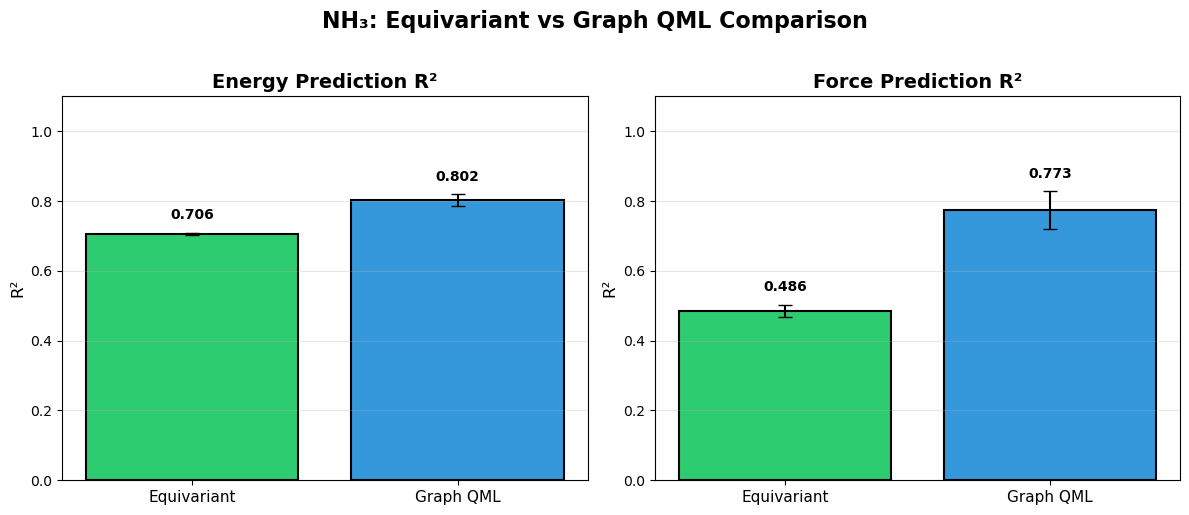

Saved: figures/comparison_mae.png


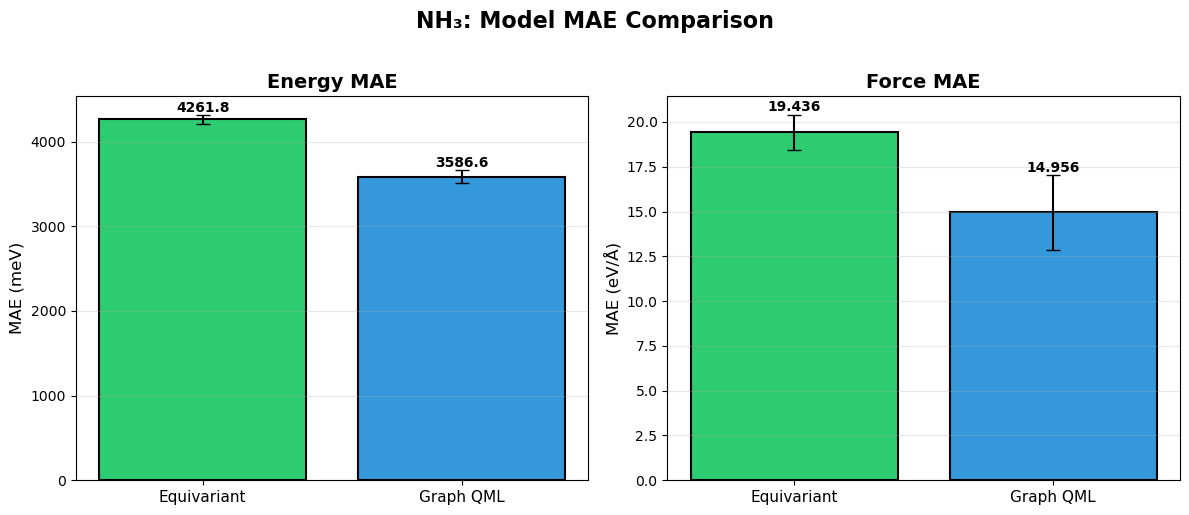

Saved: figures/training_curves.png


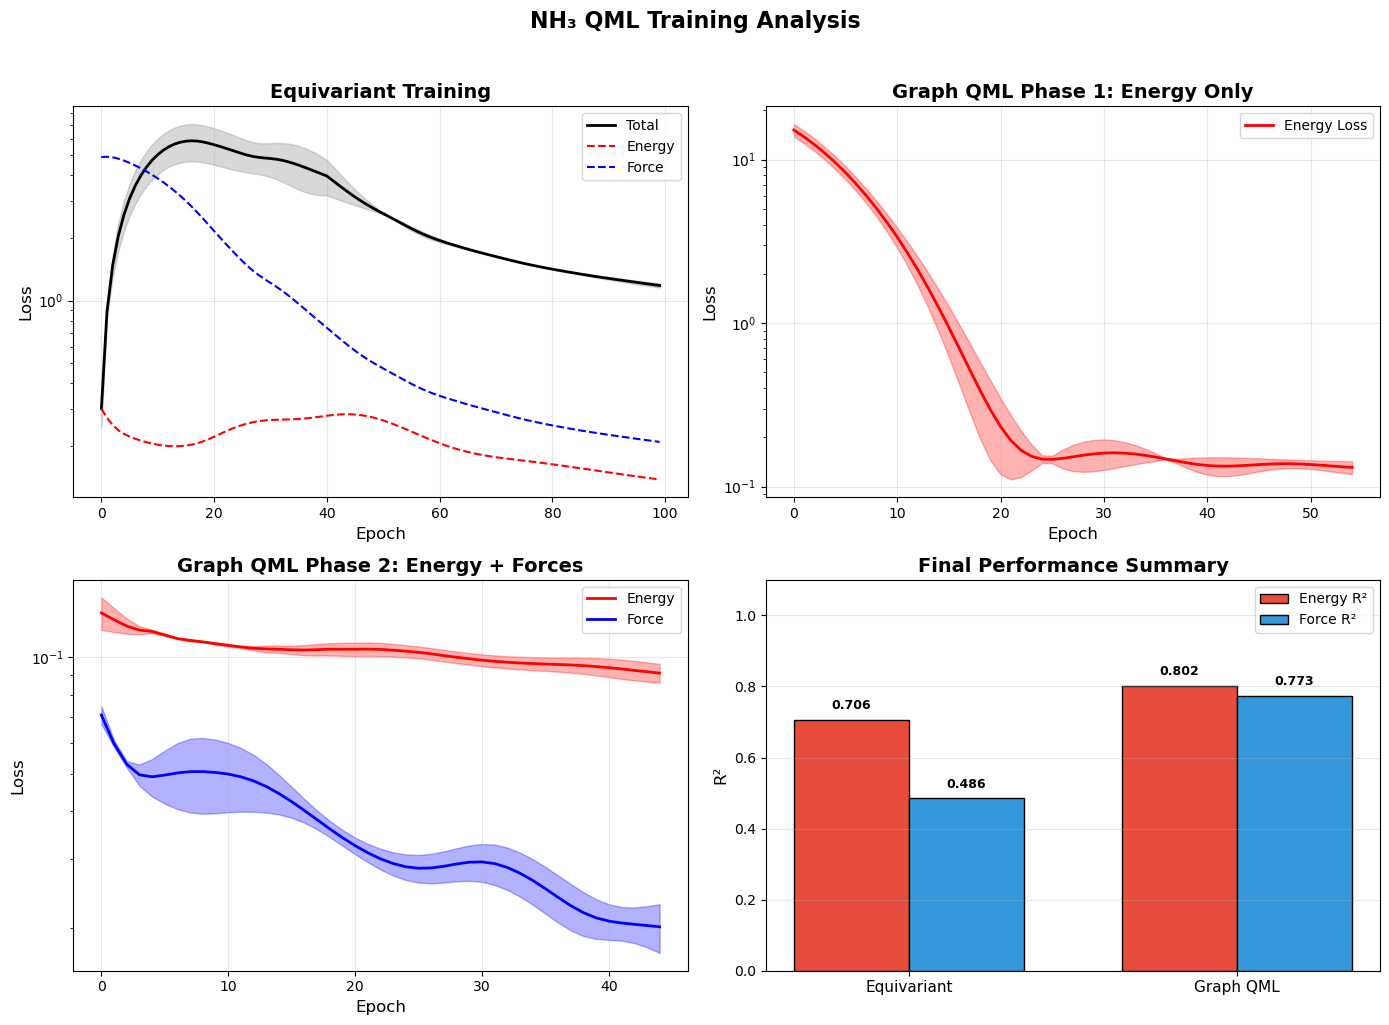

Saved: figures/predictions.png


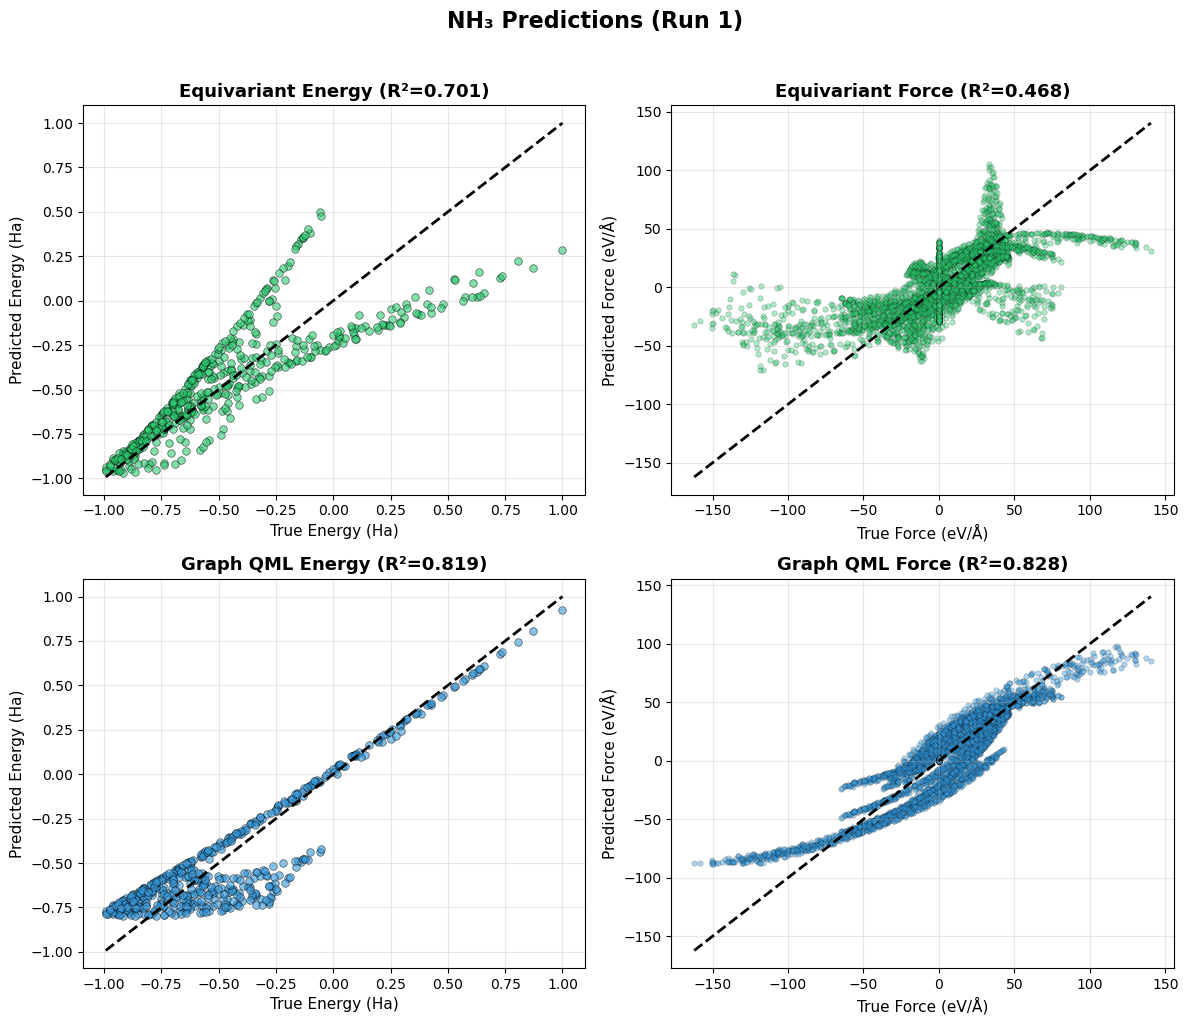

Saved: figures/force_components.png


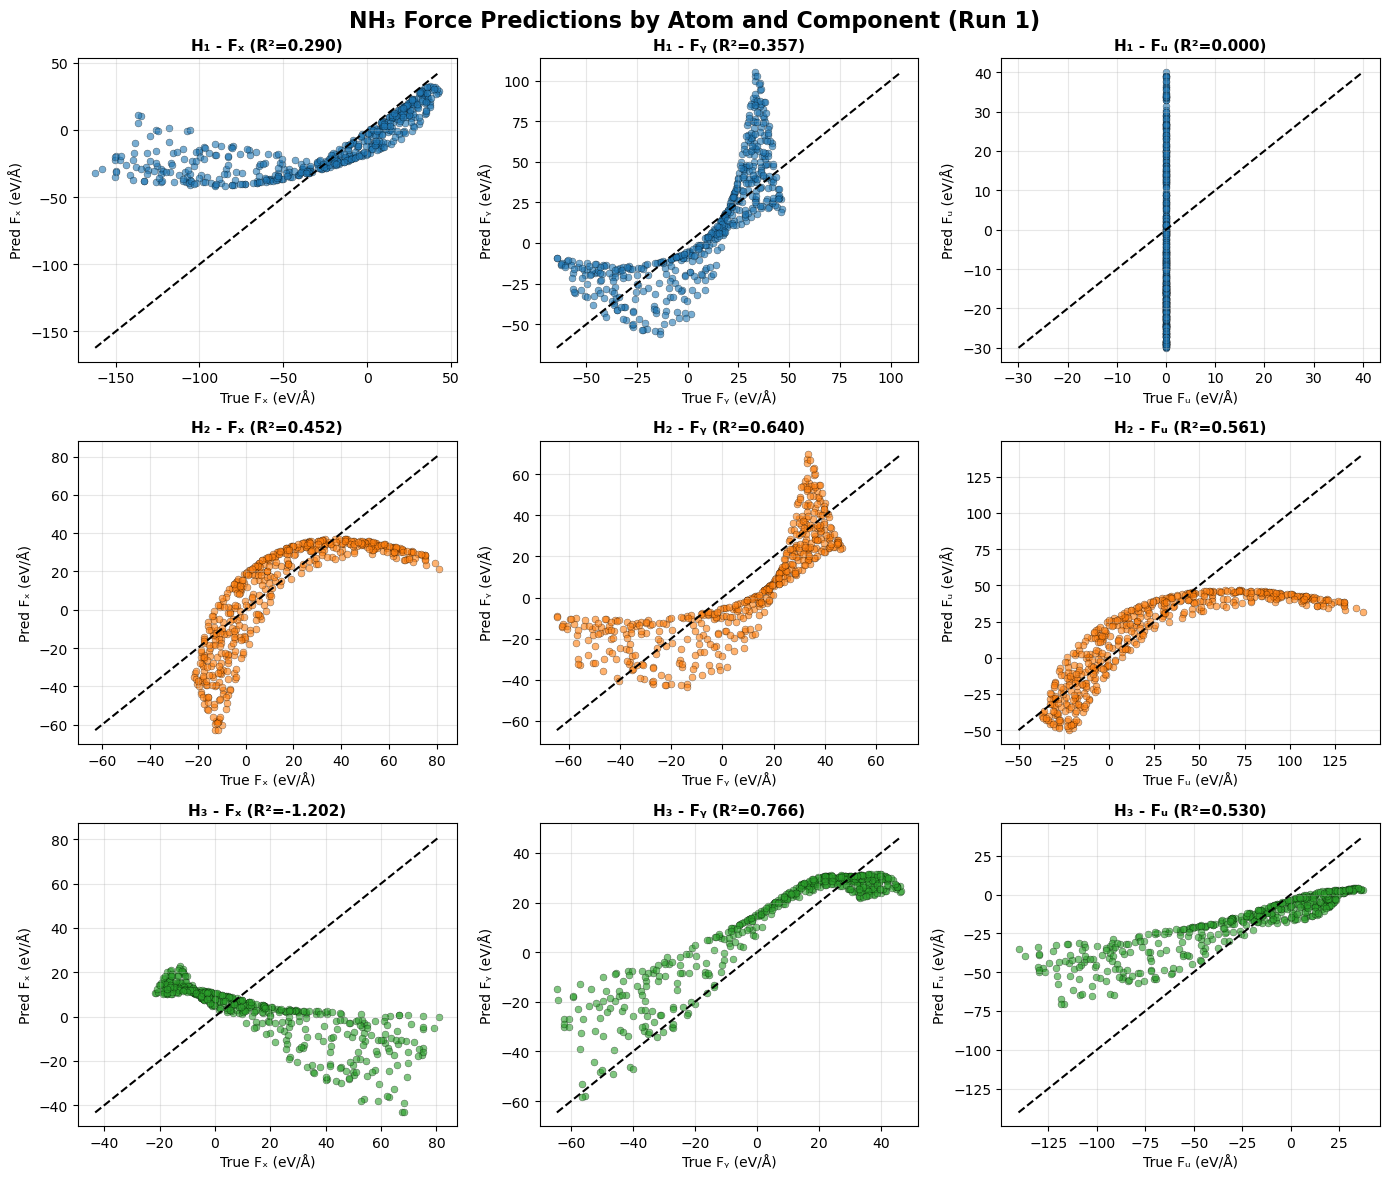


All plots saved to figures


In [3]:
reader = main('results', plot='all', save_dir='figures', show=True)

In [11]:
"""
NH₃ QML Results Reader
======================

Read and visualize results from NH₃ QML comparison experiments.

Usage (command line):
    python read_results_nh3.py ./nh3_results/ --plot all --save_dir ./nh3_results/

Usage (Jupyter):
    from read_results_nh3 import main, ResultsReader
    reader = main('./nh3_results/', plot='all', save_dir='./nh3_results/')
    # or
    reader = ResultsReader('./nh3_results/')
    reader.print_summary()
    reader.plot_comparison_bars()
"""

import numpy as np
import json
import os
import argparse
import matplotlib.pyplot as plt


class ResultsReader:
    """Read and analyze NH₃ QML comparison results."""
    
    def __init__(self, results_dir='./nh3_results/'):
        """
        Initialize reader.
        
        Args:
            results_dir: Directory containing results.json and metrics.npz (default: './nh3_results/')
        """
        self.results_dir = results_dir
        self.results = None
        self.metrics = None
        
        self._load_results()
    
    def _load_results(self):
        """Load results from JSON and NPZ files."""
        json_path = os.path.join(self.results_dir, "results.json")
        npz_path = os.path.join(self.results_dir, "metrics.npz")
        
        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                self.results = json.load(f)
            print(f"Loaded results from {json_path}")
        else:
            print(f"Warning: {json_path} not found")
        
        if os.path.exists(npz_path):
            self.metrics = dict(np.load(npz_path))
            print(f"Loaded metrics from {npz_path}")
        else:
            print(f"Warning: {npz_path} not found")
    
    def print_summary(self):
        """Print summary statistics."""
        if self.results is None:
            print("No results loaded")
            return
        
        print(f"\n{'='*70}")
        print("NH₃ QML COMPARISON SUMMARY")
        print(f"{'='*70}")
        
        meta = self.results.get("metadata", {})
        print(f"\nExperiment Details:")
        print(f"  Runs: {meta.get('n_runs', 'N/A')}")
        print(f"  Epochs: {meta.get('n_epochs', 'N/A')}")
        print(f"  Samples: {meta.get('n_samples', 'N/A')}")
        print(f"  Timestamp: {meta.get('timestamp', 'N/A')}")
        
        for model_name, display_name in [("equivariant", "Equivariant (EQNN-style)"), 
                                          ("graph_qml", "Graph QML (Non-Equivariant)")]:
            if model_name not in self.results:
                continue
            
            summary = self.results[model_name].get("summary", {})
            print(f"\n{display_name}:")
            
            if "energy_r2" in summary:
                er2 = summary["energy_r2"]
                print(f"  Energy R²:  {er2['mean']:.4f} ± {er2['std']:.4f}")
            
            if "energy_mae_ha" in summary:
                emae = summary["energy_mae_ha"]
                print(f"  Energy MAE: {emae['mean']:.6f} ± {emae['std']:.6f} Ha")
                print(f"              {emae['mean']*27.2114:.4f} ± {emae['std']*27.2114:.4f} eV")
            
            if "force_r2" in summary:
                fr2 = summary["force_r2"]
                print(f"  Force R²:   {fr2['mean']:.4f} ± {fr2['std']:.4f}")
            
            if "force_mae" in summary:
                fmae = summary["force_mae"]
                print(f"  Force MAE:  {fmae['mean']:.4f} ± {fmae['std']:.4f} eV/Å")
        
        print(f"\n{'='*70}\n")
    
    def plot_comparison_bars(self, save_path='./nh3_results/', show=True):
        """Plot R² comparison bar chart."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        models = ["Rotationally Equivariant QML", "Graph Embedding Equivariant QML"]
        colors = ["#2ecc71", "#3498db"]
        
        # Energy R²
        eq_e = self.results["equivariant"]["summary"]["energy_r2"]
        gr_e = self.results["graph_qml"]["summary"]["energy_r2"]
        
        means = [eq_e["mean"], gr_e["mean"]]
        stds = [eq_e["std"], gr_e["std"]]
        
        x = np.arange(len(models))
        bars = axes[0].bar(x, means, yerr=stds, capsize=5, color=colors, 
                          edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel("R²", fontsize=12)
        axes[0].set_title("Energy Prediction R²", fontsize=14, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(models, fontsize=11)
        axes[0].set_ylim([0, 1.1])
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, m, s in zip(bars, means, stds):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + s + 0.03,
                        f'{m:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Force R²
        eq_f = self.results["equivariant"]["summary"]["force_r2"]
        gr_f = self.results["graph_qml"]["summary"]["force_r2"]
        
        means = [eq_f["mean"], gr_f["mean"]]
        stds = [eq_f["std"], gr_f["std"]]
        
        bars = axes[1].bar(x, means, yerr=stds, capsize=5, color=colors,
                          edgecolor='black', linewidth=1.5)
        axes[1].set_ylabel("R²", fontsize=12)
        axes[1].set_title("Force Prediction R²", fontsize=14, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(models, fontsize=11)
        axes[1].set_ylim([0, 1.1])
        axes[1].grid(True, alpha=0.3, axis='y')
        
        for bar, m, s in zip(bars, means, stds):
            height = max(0, bar.get_height())
            axes[1].text(bar.get_x() + bar.get_width()/2, height + s + 0.03,
                        f'{m:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.suptitle("NH₃: Rotationally Equivariant vs Graph Embedding Equivariant QML Comparison", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_mae_comparison(self, save_path='./nh3_results/', show=True):
        """Plot MAE comparison bar chart."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        models = ["Rotationally Equivariant QML", "Graph Embedding Equivariant QML"]
        colors = ["#2ecc71", "#3498db"]
        x = np.arange(len(models))
        
        # Energy MAE (in meV)
        eq_e = self.results["equivariant"]["summary"]["energy_mae_ha"]
        gr_e = self.results["graph_qml"]["summary"]["energy_mae_ha"]
        
        # Convert to meV (1 Ha = 27211.4 meV)
        means = [eq_e["mean"] * 27211.4, gr_e["mean"] * 27211.4]
        stds = [eq_e["std"] * 27211.4, gr_e["std"] * 27211.4]
        
        bars = axes[0].bar(x, means, yerr=stds, capsize=5, color=colors,
                          edgecolor='black', linewidth=1.5)
        axes[0].set_ylabel("MAE (meV)", fontsize=12)
        axes[0].set_title("Energy MAE", fontsize=14, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(models, fontsize=11)
        axes[0].grid(True, alpha=0.3, axis='y')
        
        for bar, m, s in zip(bars, means, stds):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + s + 0.5,
                        f'{m:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Force MAE
        eq_f = self.results["equivariant"]["summary"]["force_mae"]
        gr_f = self.results["graph_qml"]["summary"]["force_mae"]
        
        means = [eq_f["mean"], gr_f["mean"]]
        stds = [eq_f["std"], gr_f["std"]]
        
        bars = axes[1].bar(x, means, yerr=stds, capsize=5, color=colors,
                          edgecolor='black', linewidth=1.5)
        axes[1].set_ylabel("MAE (eV/Å)", fontsize=12)
        axes[1].set_title("Force MAE", fontsize=14, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(models, fontsize=11)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        for bar, m, s in zip(bars, means, stds):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + s + 0.02,
                        f'{m:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.suptitle("NH₃: Model MAE Comparison", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_training_curves(self, save_path='./nh3_results/', show=True):
        """Plot training loss curves."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Equivariant training curves
        eq_runs = self.results["equivariant"]["runs"]
        
        # Collect all histories
        eq_total = []
        eq_energy = []
        eq_force = []
        
        for run in eq_runs:
            history = run.get("history", {})
            if "total" in history:
                eq_total.append(history["total"])
            if "energy" in history:
                eq_energy.append(history["energy"])
            if "force" in history:
                eq_force.append(history["force"])
        
        if eq_total:
            eq_total = np.array(eq_total)
            mean = np.mean(eq_total, axis=0)
            std = np.std(eq_total, axis=0)
            steps = np.arange(len(mean))
            
            axes[0, 0].plot(steps, mean, 'k-', lw=2, label='Total')
            axes[0, 0].fill_between(steps, mean - std, mean + std, alpha=0.3, color='gray')
            
            if eq_energy:
                eq_energy = np.array(eq_energy)
                mean_e = np.mean(eq_energy, axis=0)
                axes[0, 0].plot(steps, mean_e, 'r--', lw=1.5, label='Energy')
            
            if eq_force:
                eq_force = np.array(eq_force)
                mean_f = np.mean(eq_force, axis=0)
                axes[0, 0].plot(steps, mean_f, 'b--', lw=1.5, label='Force')
        
        axes[0, 0].set_yscale('log')
        axes[0, 0].set_xlabel('Epoch', fontsize=12)
        axes[0, 0].set_ylabel('Loss', fontsize=12)
        axes[0, 0].set_title('Rotationally Equivariant QML Training', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Graph QML training curves - Phase 1 (Energy)
        graph_runs = self.results["graph_qml"]["runs"]
        
        graph_energy_phase = []
        for run in graph_runs:
            history = run.get("history", {})
            if "energy_phase" in history:
                graph_energy_phase.append(history["energy_phase"])
        
        if graph_energy_phase:
            # Pad to same length
            max_len = max(len(h) for h in graph_energy_phase)
            padded = []
            for h in graph_energy_phase:
                if len(h) < max_len:
                    h = h + [h[-1]] * (max_len - len(h))
                padded.append(h)
            
            graph_energy_phase = np.array(padded)
            mean = np.mean(graph_energy_phase, axis=0)
            std = np.std(graph_energy_phase, axis=0)
            steps = np.arange(len(mean))
            
            axes[0, 1].plot(steps, mean, 'r-', lw=2, label='Energy Loss')
            axes[0, 1].fill_between(steps, mean - std, mean + std, alpha=0.3, color='red')
        
        axes[0, 1].set_yscale('log')
        axes[0, 1].set_xlabel('Epoch', fontsize=12)
        axes[0, 1].set_ylabel('Loss', fontsize=12)
        axes[0, 1].set_title('Graph Embedding Equivariant QML Phase 1: Energy Only', fontsize=14, fontweight='bold')
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Graph QML training curves - Phase 2 (Combined)
        graph_combined_E = []
        graph_combined_F = []
        
        for run in graph_runs:
            history = run.get("history", {})
            if "combined_E" in history:
                graph_combined_E.append(history["combined_E"])
            if "combined_F" in history:
                graph_combined_F.append(history["combined_F"])
        
        if graph_combined_E:
            max_len = max(len(h) for h in graph_combined_E)
            padded_E = []
            padded_F = []
            for e, f in zip(graph_combined_E, graph_combined_F):
                if len(e) < max_len:
                    e = e + [e[-1]] * (max_len - len(e))
                    f = f + [f[-1]] * (max_len - len(f))
                padded_E.append(e)
                padded_F.append(f)
            
            graph_combined_E = np.array(padded_E)
            graph_combined_F = np.array(padded_F)
            
            steps = np.arange(graph_combined_E.shape[1])
            
            mean_E = np.mean(graph_combined_E, axis=0)
            std_E = np.std(graph_combined_E, axis=0)
            axes[1, 0].plot(steps, mean_E, 'r-', lw=2, label='Energy')
            axes[1, 0].fill_between(steps, mean_E - std_E, mean_E + std_E, alpha=0.3, color='red')
            
            mean_F = np.mean(graph_combined_F, axis=0)
            std_F = np.std(graph_combined_F, axis=0)
            axes[1, 0].plot(steps, mean_F, 'b-', lw=2, label='Force')
            axes[1, 0].fill_between(steps, mean_F - std_F, mean_F + std_F, alpha=0.3, color='blue')
        
        axes[1, 0].set_yscale('log')
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('Loss', fontsize=12)
        axes[1, 0].set_title('Graph Embedding Equivariant QML Phase 2: Energy + Forces', fontsize=14, fontweight='bold')
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Summary comparison
        summary_data = {
            'Rotationally Equivariant QML': {
                'E_R²': self.results["equivariant"]["summary"]["energy_r2"]["mean"],
                'F_R²': self.results["equivariant"]["summary"]["force_r2"]["mean"],
            },
            'Graph Embedding Equivariant QML': {
                'E_R²': self.results["graph_qml"]["summary"]["energy_r2"]["mean"],
                'F_R²': self.results["graph_qml"]["summary"]["force_r2"]["mean"],
            }
        }
        
        models = list(summary_data.keys())
        x = np.arange(len(models))
        width = 0.35
        
        e_r2 = [summary_data[m]['E_R²'] for m in models]
        f_r2 = [summary_data[m]['F_R²'] for m in models]
        
        axes[1, 1].bar(x - width/2, e_r2, width, label='Energy R²', color='#e74c3c', edgecolor='black')
        axes[1, 1].bar(x + width/2, f_r2, width, label='Force R²', color='#3498db', edgecolor='black')
        
        axes[1, 1].set_ylabel('R²', fontsize=12)
        axes[1, 1].set_title('Final Performance Summary', fontsize=14, fontweight='bold')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(models, fontsize=11)
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].set_ylim([0, 1.1])
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (e, f) in enumerate(zip(e_r2, f_r2)):
            axes[1, 1].text(i - width/2, e + 0.03, f'{e:.3f}', ha='center', fontsize=9, fontweight='bold')
            axes[1, 1].text(i + width/2, max(0, f) + 0.03, f'{f:.3f}', ha='center', fontsize=9, fontweight='bold')
        
        plt.suptitle("NH₃ QML Training Analysis", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_predictions(self, run_idx=0, save_path='./nh3_results/', show=True):
        """Plot prediction scatter plots for a specific run."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Get predictions from specified run
        eq_run = self.results["equivariant"]["runs"][run_idx]
        graph_run = self.results["graph_qml"]["runs"][run_idx]
        
        eq_preds = eq_run["metrics"]["predictions"]
        graph_preds = graph_run["metrics"]["predictions"]
        
        # Equivariant Energy
        E_true = np.array(eq_preds["E_true"])
        E_pred = np.array(eq_preds["E_pred"])
        
        axes[0, 0].scatter(E_true, E_pred, alpha=0.6, s=30, c='#2ecc71', edgecolors='black', linewidth=0.5)
        lims = [min(E_true.min(), E_pred.min()), max(E_true.max(), E_pred.max())]
        axes[0, 0].plot(lims, lims, 'k--', lw=2)
        axes[0, 0].set_xlabel('True Energy (Ha)', fontsize=11)
        axes[0, 0].set_ylabel('Predicted Energy (Ha)', fontsize=11)
        r2 = eq_run["metrics"]["energy"]["r2"]
        axes[0, 0].set_title(f'Rotationally Equivariant QML Energy (R²={r2:.3f})', fontsize=13, fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Equivariant Force
        F_true = np.array(eq_preds["F_true"]).flatten()
        F_pred = np.array(eq_preds["F_pred"]).flatten()
        
        axes[0, 1].scatter(F_true, F_pred, alpha=0.4, s=15, c='#2ecc71', edgecolors='black', linewidth=0.3)
        lims = [min(F_true.min(), F_pred.min()), max(F_true.max(), F_pred.max())]
        axes[0, 1].plot(lims, lims, 'k--', lw=2)
        axes[0, 1].set_xlabel('True Force (eV/Å)', fontsize=11)
        axes[0, 1].set_ylabel('Predicted Force (eV/Å)', fontsize=11)
        r2 = eq_run["metrics"]["force"]["r2"]
        axes[0, 1].set_title(f'Rotationally Equivariant QML Force (R²={r2:.3f})', fontsize=13, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Graph QML Energy
        E_true = np.array(graph_preds["E_true"])
        E_pred = np.array(graph_preds["E_pred"])
        
        axes[1, 0].scatter(E_true, E_pred, alpha=0.6, s=30, c='#3498db', edgecolors='black', linewidth=0.5)
        lims = [min(E_true.min(), E_pred.min()), max(E_true.max(), E_pred.max())]
        axes[1, 0].plot(lims, lims, 'k--', lw=2)
        axes[1, 0].set_xlabel('True Energy (Ha)', fontsize=11)
        axes[1, 0].set_ylabel('Predicted Energy (Ha)', fontsize=11)
        r2 = graph_run["metrics"]["energy"]["r2"]
        axes[1, 0].set_title(f'Graph Embedding Equivariant QML Energy (R²={r2:.3f})', fontsize=13, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Graph QML Force
        F_true = np.array(graph_preds["F_true"]).flatten()
        F_pred = np.array(graph_preds["F_pred"]).flatten()
        
        axes[1, 1].scatter(F_true, F_pred, alpha=0.4, s=15, c='#3498db', edgecolors='black', linewidth=0.3)
        lims = [min(F_true.min(), F_pred.min()), max(F_true.max(), F_pred.max())]
        axes[1, 1].plot(lims, lims, 'k--', lw=2)
        axes[1, 1].set_xlabel('True Force (eV/Å)', fontsize=11)
        axes[1, 1].set_ylabel('Predicted Force (eV/Å)', fontsize=11)
        r2 = graph_run["metrics"]["force"]["r2"]
        axes[1, 1].set_title(f'Graph Embedding Equivariant QML Force (R²={r2:.3f})', fontsize=13, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f"NH₃ Predictions (Run {run_idx + 1})", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_force_components(self, run_idx=0, save_path='./nh3_results/', show=True):
        """Plot force predictions by atom and component."""
        if self.results is None:
            print("No results to plot")
            return
        
        fig, axes = plt.subplots(3, 3, figsize=(14, 12))
        fig.suptitle(f'NH₃ Force Predictions by Atom and Component (Run {run_idx + 1})', 
                     fontsize=16, fontweight='bold')
        
        atom_names = ['H₁', 'H₂', 'H₃']
        component_names = ['Fₓ', 'Fᵧ', 'Fᵤ']
        
        # Use equivariant predictions (or could compare both)
        eq_run = self.results["equivariant"]["runs"][run_idx]
        preds = eq_run["metrics"]["predictions"]
        
        F_true = np.array(preds["F_true"])  # (N_test, 3, 3)
        F_pred = np.array(preds["F_pred"])  # (N_test, 3, 3)
        
        for atom_idx in range(3):
            for comp_idx in range(3):
                ax = axes[atom_idx, comp_idx]
                
                f_true = F_true[:, atom_idx, comp_idx]
                f_pred = F_pred[:, atom_idx, comp_idx]
                
                ax.scatter(f_true, f_pred, alpha=0.6, s=25, c=f'C{atom_idx}', 
                          edgecolors='black', linewidth=0.3)
                
                lims = [min(f_true.min(), f_pred.min()), max(f_true.max(), f_pred.max())]
                ax.plot(lims, lims, 'k--', lw=1.5)
                
                # Compute R² for this component
                ss_res = np.sum((f_pred - f_true)**2)
                ss_tot = np.sum((f_true - f_true.mean())**2)
                r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0
                
                ax.set_xlabel(f'True {component_names[comp_idx]} (eV/Å)', fontsize=10)
                ax.set_ylabel(f'Pred {component_names[comp_idx]} (eV/Å)', fontsize=10)
                ax.set_title(f'{atom_names[atom_idx]} - {component_names[comp_idx]} (R²={r2:.3f})', 
                            fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def plot_all(self, output_dir=None, show=True):
        """Generate all plots."""
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
        
        self.plot_comparison_bars(
            save_path=os.path.join(output_dir, "comparison_r2.png") if output_dir else None,
            show=show
        )
        
        self.plot_mae_comparison(
            save_path=os.path.join(output_dir, "comparison_mae.png") if output_dir else None,
            show=show
        )
        
        self.plot_training_curves(
            save_path=os.path.join(output_dir, "training_curves.png") if output_dir else None,
            show=show
        )
        
        self.plot_predictions(
            save_path=os.path.join(output_dir, "predictions.png") if output_dir else None,
            show=show
        )
        
        self.plot_force_components(
            save_path=os.path.join(output_dir, "force_components.png") if output_dir else None,
            show=show
        )
        
        if output_dir:
            print(f"\nAll plots saved to {output_dir}")
    
    def export_csv(self, filepath):
        """Export summary to CSV."""
        if self.results is None:
            print("No results to export")
            return
        
        lines = ["Model,Metric,Mean,Std"]
        
        for model_name, display_name in [("equivariant", "Equivariant"), ("graph_qml", "Graph_QML")]:
            summary = self.results[model_name]["summary"]
            
            lines.append(f"{display_name},Energy_R2,{summary['energy_r2']['mean']:.6f},{summary['energy_r2']['std']:.6f}")
            lines.append(f"{display_name},Energy_MAE_Ha,{summary['energy_mae_ha']['mean']:.6f},{summary['energy_mae_ha']['std']:.6f}")
            lines.append(f"{display_name},Force_R2,{summary['force_r2']['mean']:.6f},{summary['force_r2']['std']:.6f}")
            lines.append(f"{display_name},Force_MAE,{summary['force_mae']['mean']:.6f},{summary['force_mae']['std']:.6f}")
        
        with open(filepath, "w") as f:
            f.write("\n".join(lines))
        
        print(f"Exported to {filepath}")


def main(results_dir='./nh3_results/', plot='all', save_dir='./nh3_results/', csv=None, show=True):
    """
    Main function - can be called directly from Jupyter or command line.
    
    Args:
        results_dir: Directory containing results (default: './nh3_results/')
        plot: Type of plot ('comparison', 'mae', 'training', 'predictions', 'force_components', 'all')
        save_dir: Directory to save plots (default: './nh3_results/')
        csv: Path to export CSV (optional)
        show: Whether to display plots
    
    Returns:
        ResultsReader object
    """
    reader = ResultsReader(results_dir)
    reader.print_summary()
    
    if csv:
        reader.export_csv(csv)
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    if plot == 'all':
        reader.plot_all(output_dir=save_dir, show=show)
    elif plot == 'comparison':
        path = os.path.join(save_dir, "comparison_r2.png") if save_dir else None
        reader.plot_comparison_bars(save_path=path, show=show)
    elif plot == 'mae':
        path = os.path.join(save_dir, "comparison_mae.png") if save_dir else None
        reader.plot_mae_comparison(save_path=path, show=show)
    elif plot == 'training':
        path = os.path.join(save_dir, "training_curves.png") if save_dir else None
        reader.plot_training_curves(save_path=path, show=show)
    elif plot == 'predictions':
        path = os.path.join(save_dir, "predictions.png") if save_dir else None
        reader.plot_predictions(save_path=path, show=show)
    elif plot == 'force_components':
        path = os.path.join(save_dir, "force_components.png") if save_dir else None
        reader.plot_force_components(save_path=path, show=show)
    
    return reader


if __name__ == "__main__":
    import sys
    
    # Check if running in Jupyter
    if 'ipykernel' in sys.modules:
        print("Running in Jupyter notebook. Call main() directly with parameters:")
        print("  reader = main('./nh3_results/', plot='all', save_dir='./nh3_results/', show=True)")
        print("\nOr use the ResultsReader class directly:")
        print("  reader = ResultsReader('./nh3_results/')")
        print("  reader.print_summary()")
        print("  reader.plot_comparison_bars()")
    else:
        parser = argparse.ArgumentParser(description="Read and analyze NH₃ QML comparison results")
        parser.add_argument("results_dir", nargs='?', default='./nh3_results/', help="Directory containing results (default: './nh3_results/')")
        parser.add_argument("--plot", choices=['comparison', 'mae', 'training', 'predictions', 'force_components', 'all'],
                           default='all', help="Type of plot")
        parser.add_argument("--save_dir", type=str, default='./nh3_results/', help="Directory to save plots")
        parser.add_argument("--csv", type=str, help="Export to CSV")
        parser.add_argument("--no-show", action="store_true", help="Don't display plots")
        
        args = parser.parse_args()
        
        main(
            results_dir=args.results_dir,
            plot=args.plot,
            save_dir=args.save_dir,
            csv=args.csv,
            show=not args.no_show
        )

Running in Jupyter notebook. Call main() directly with parameters:
  reader = main('./nh3_results/', plot='all', save_dir='./nh3_results/', show=True)

Or use the ResultsReader class directly:
  reader = ResultsReader('./nh3_results/')
  reader.print_summary()
  reader.plot_comparison_bars()


Loaded results from nh3_results/results.json
Loaded metrics from nh3_results/metrics.npz

NH₃ QML COMPARISON SUMMARY

Experiment Details:
  Runs: 1
  Epochs: 400
  Samples: 2400
  Timestamp: 2025-11-26T01:18:02.828969

Equivariant (EQNN-style):
  Energy R²:  0.9578 ± 0.0000
  Energy MAE: 0.062597 ± 0.000000 Ha
              1.7034 ± 0.0000 eV
  Force R²:   0.9566 ± 0.0000
  Force MAE:  5.7552 ± 0.0000 eV/Å

Graph QML (Non-Equivariant):
  Energy R²:  0.9355 ± 0.0000
  Energy MAE: 0.084569 ± 0.000000 Ha
              2.3012 ± 0.0000 eV
  Force R²:   0.9491 ± 0.0000
  Force MAE:  6.8564 ± 0.0000 eV/Å


Saved: ./nh3_results/comparison_r2.png


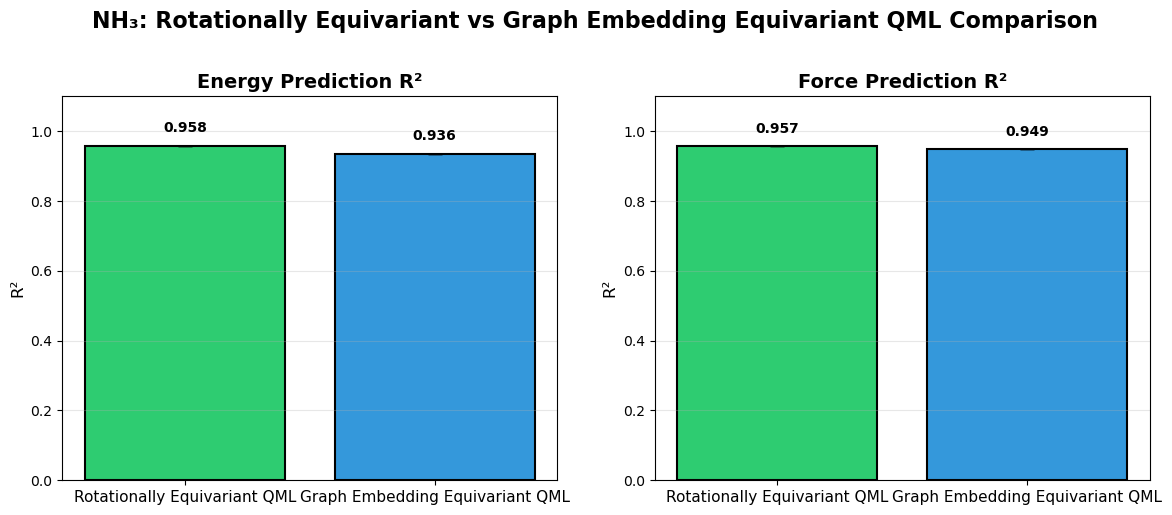

Saved: ./nh3_results/comparison_mae.png


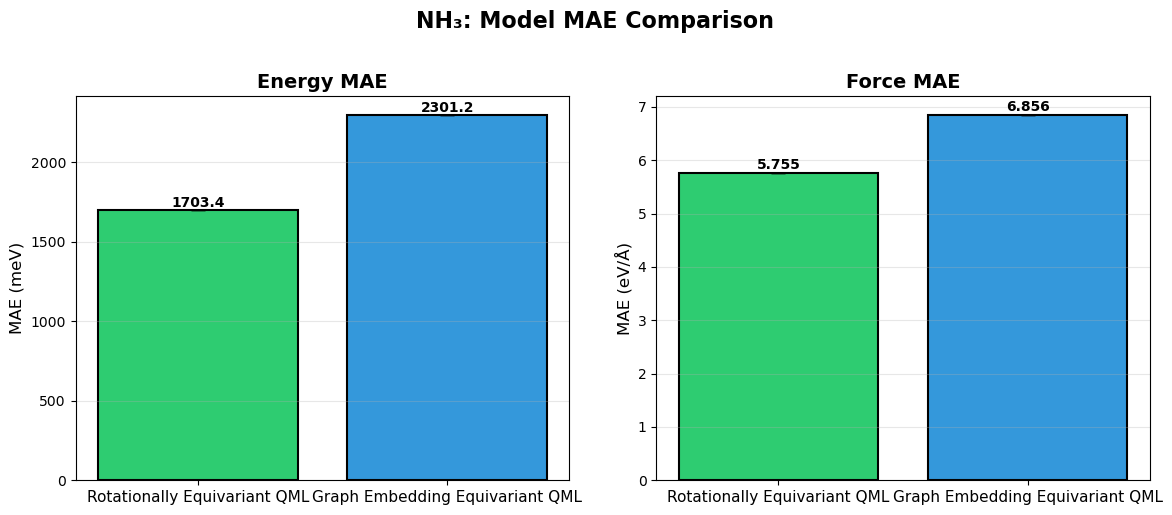

Saved: ./nh3_results/training_curves.png


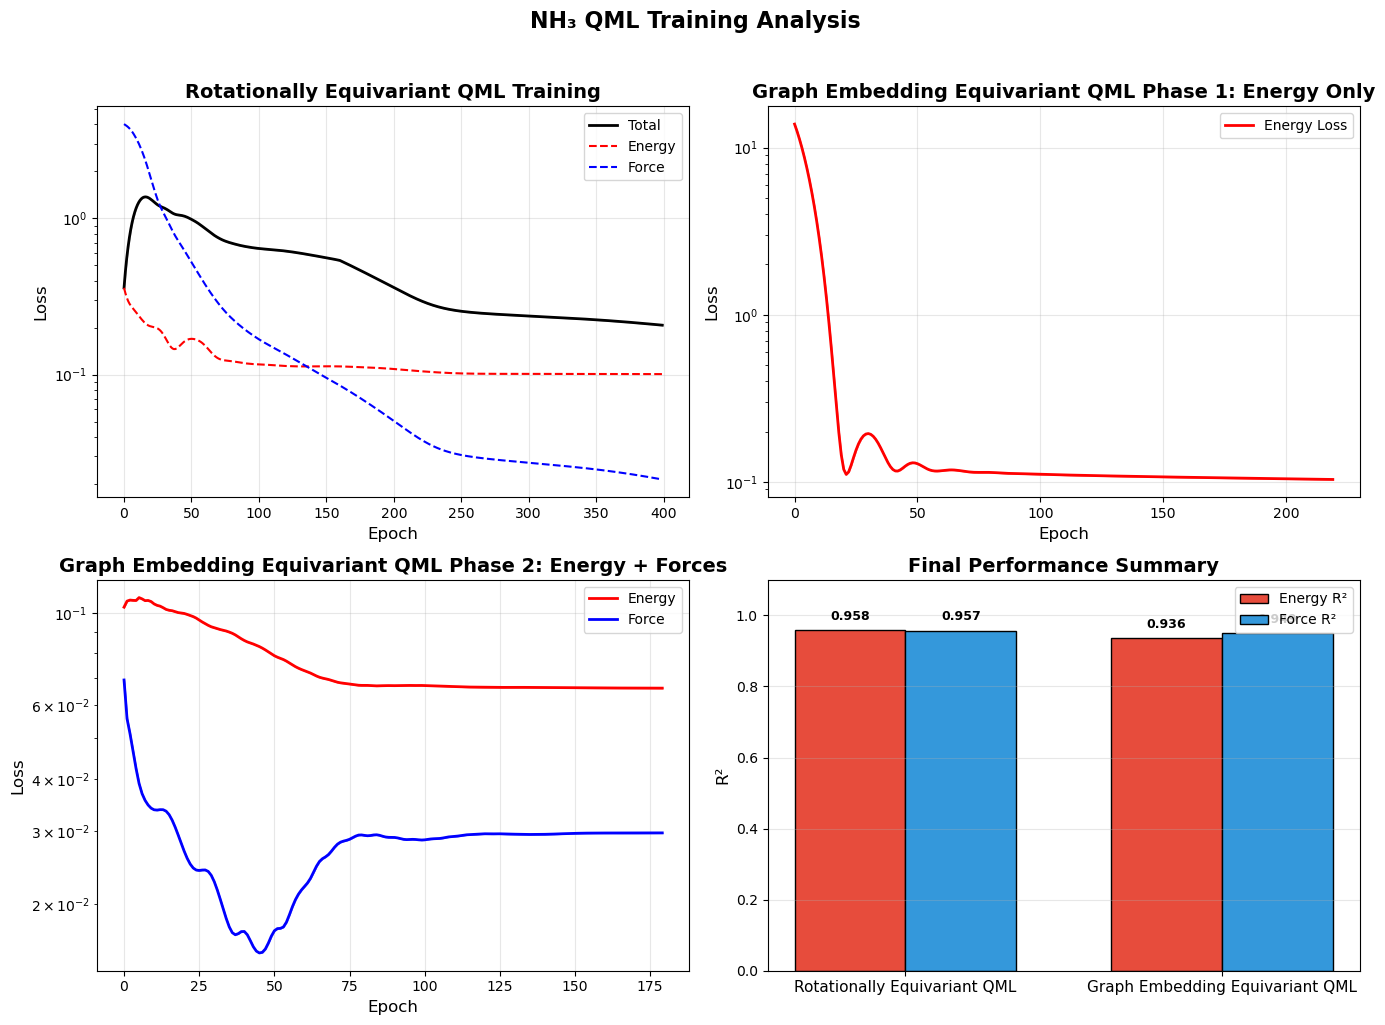

Saved: ./nh3_results/predictions.png


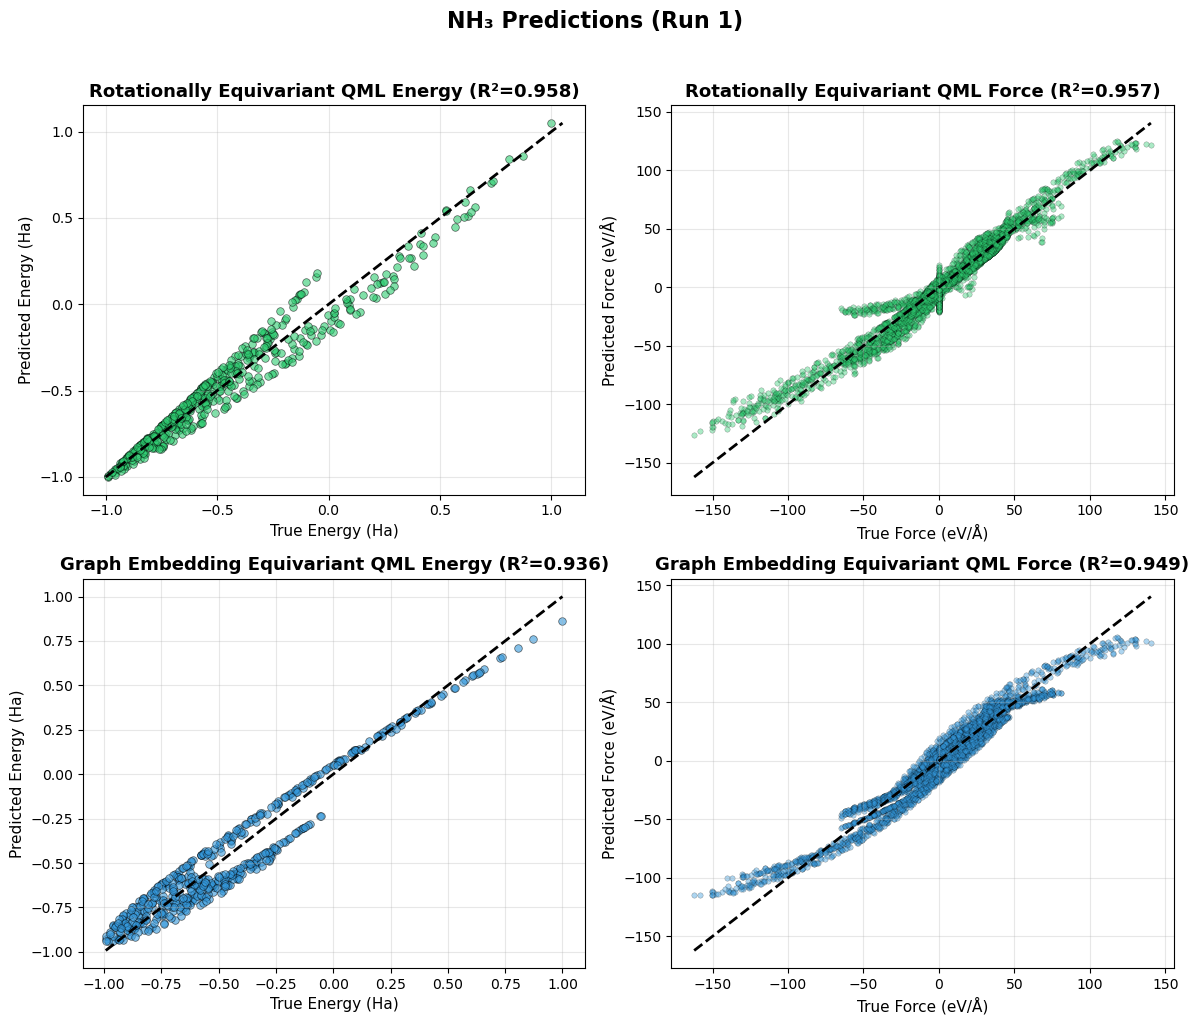

Saved: ./nh3_results/force_components.png


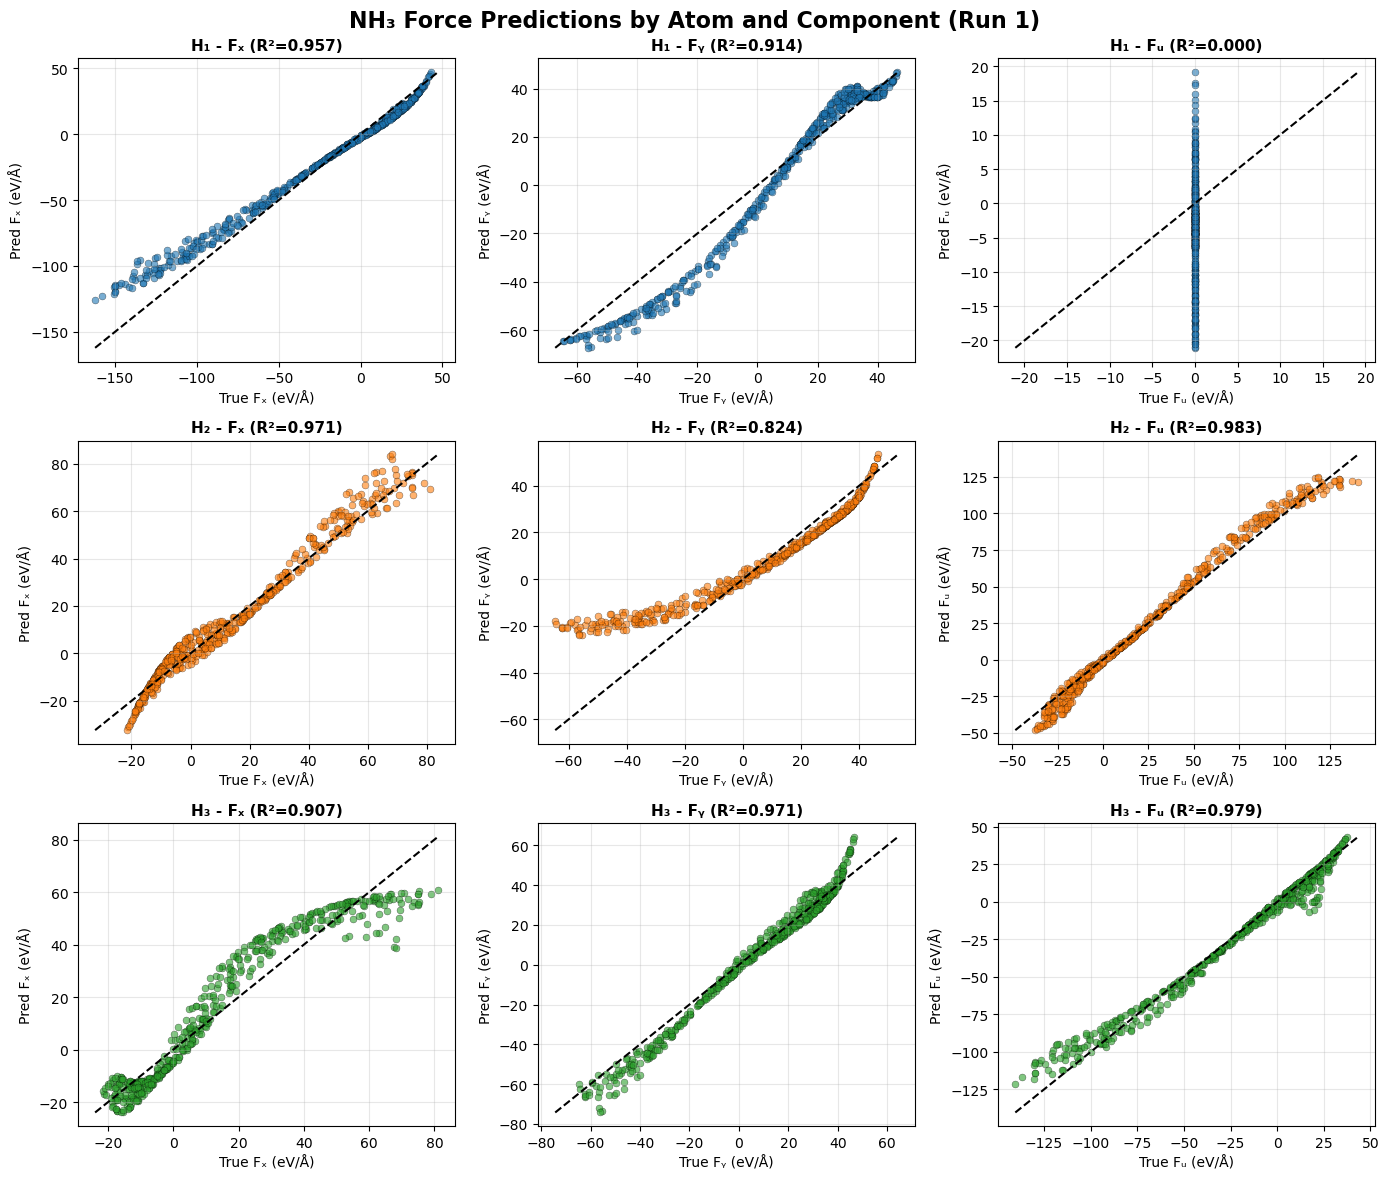


All plots saved to ./nh3_results/


In [13]:
reader = main('nh3_results', plot='all', save_dir='./nh3_results/', show=True)